# Citizen weather stations quality checks

Citizen weather stations CWS provide an unprecedented potential for high-resolution climate modeling, especially in urban environments where the spatial density of stations can be very high [1,2]. To that end, Meteora features the `NetatmoClient`, which makes it easy to access [public data from Netatmo weather stations](https://weathermap.netatmo.com) (one of the major CWS providers).

However, since there is no guarantee that the scientific guidelines to properly set up meteorological stations have been met for CWS, performing a quality control (QC) of the collected CWS data is a crucial prerequisite before any analysis can be conducted. To that end, Meteora features the `qc` module, which is based on Napoly et al., (2018) [3] and implements a set of statistically-based QC methods that control for common errors in CWS observations. Note that this QC methods are designed to detect stations with **suspicious temperature measurements and therefore may not be appropriate to use on other meteorological variables**.

In [ ]:
import os

import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from meteora import qc, utils
from meteora.clients import AgrometeoClient, GHCNHourlyClient, NetatmoClient

figwidth = plt.rcParams["figure.figsize"][0]
figheight = plt.rcParams["figure.figsize"][1]

We will start by using the `NetatmoClient` to get CWS data for a bounding box in the Lavaux region of Switzerland. In order to use the `NetatmoClient`, we need to obtain a client ID and secret (see the detailed steps [in the dedicated section of the Meteora documentation](https://meteora.readthedocs.io/en/latest/supported-providers.html#netatmo)).

In [ ]:
# region = [6.44134, 46.47404, 6.51232, 46.52273]
# region = [6.4256, 46.4698, 6.5750, 46.5435]
# region = [6.81444, 46.44590, 6.88483, 46.48373]
region = [6.6469, 46.4799, 6.7346, 46.5250]
crs = "epsg:4326"
client_id = os.getenv("NETATMO_CLIENT_ID", default="")
client_secret = os.getenv("NETATMO_CLIENT_SECRET", default="")
client_id = "60faf460f9726164b520353d"
client_secret = "h4NJJ2Mu7JPI6IPVNpjVnBtCdf8omINfCQ4uqhjLvr0"
scale = "1hour"  # default is "30min"

Given the client ID and secret, we can pass them to the instantiation of the `NetatmoClient`, which will then open a browser window asking us to authorize our application (that we used to get the client ID and secret) to access the data from the Netatmo weather stations. After accepting, we will be redirected to the page with the list of your accounts applications. At the end of the URL bar there will be an authorization code preceded by `code=`, which we will have to copy and enter into the input window that will appear when we execute the cell below:

In [ ]:
client = NetatmoClient(region, client_id, client_secret)

Like in any other Meteora client, we can start by plotting the station locations:

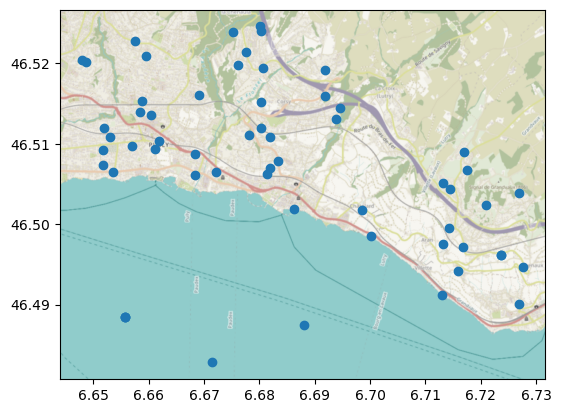

In [ ]:
ax = client.stations_gdf.plot()
cx.add_basemap(ax=ax, crs=client.stations_gdf.crs, attribution="")

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

## Mislocated stations

Before retrieving any time series data, we can filter out some locations just based on their geolocation using the `meteora.qc.get_mislocated_stations_method`, which will return the list of station ids (index keys in `client.stations_gdf`) that are considered mislocated. As noted by Meier et al. (2017) [2], many Netatmo stations show identical geolocation, which is likely because an inadequate set up "led to automated location assignment based on the IP address of the wireless network" [3] (page 4). Let us plot them in a map:

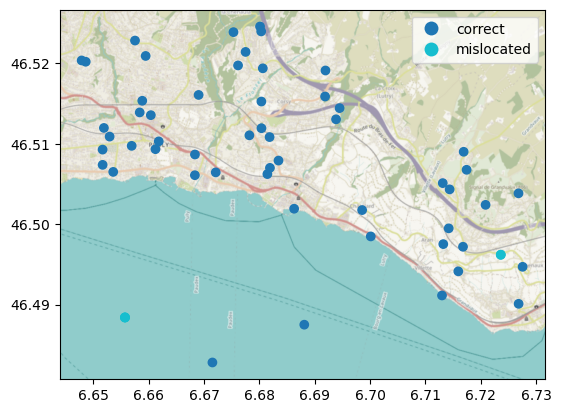

In [ ]:
mislocated_stations = qc.get_mislocated_stations(client.stations_gdf["geometry"])
ax = client.stations_gdf.assign(
    label=[
        "mislocated" if i in mislocated_stations else "correct"
        for i in client.stations_gdf.index
    ]
).plot("label", legend=True)
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution="")

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

As we can see, some of the mislocated stations, but not all of them, are on Lake Geneva. The other stations on the lake are likely mislocated too and can be filtered out using an ad-hoc method.

Let us now get a time series of data during a heatwave in August 2023, defined as at least 3 consecutive days with an average temperature over 25$^{\circ}$C ([based on the heat level warning definitions by MeteoSwiss](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/heat-warnings.html)):

In [ ]:
variables = ["temperature"]
start = "18-08-2023"
end = "25-08-2023"
long_ts_df = client.get_ts_df(variables, start, end, scale=scale)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:55<00:00,  1.06it/s]


We can now plot the time series of CWS observations. Since there are 59 CWS in the study area (number of rows in `client.stations_gdf`), we can use the [`seaborn.lineplot`](https://seaborn.pydata.org/generated/seaborn.lineplot.html) function to plot the mean and 95% confidence intervals at each temporal cross-section:

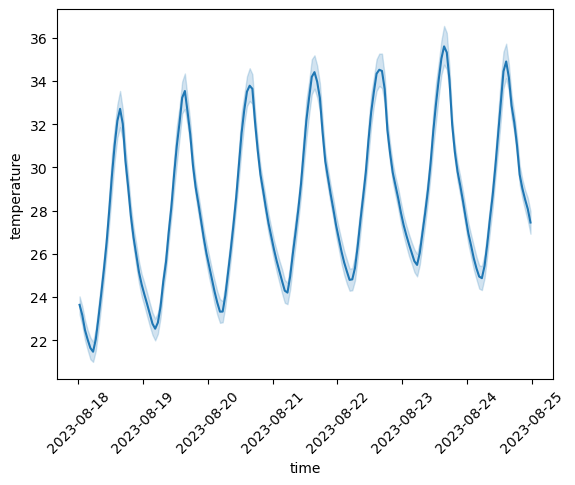

In [ ]:
ax = sns.lineplot(long_ts_df.reset_index(), x="time", y="temperature")
ax.tick_params(axis="x", labelrotation=45)

The `get_ts_df` method of all Meteora clients returns a [long-form time series data frames](https://meteora.readthedocs.io/en/latest/user-guide/data-structures.html#Long-data-frames), multi-indexed by stations (first-level) and time (second-level) and with variables as columns. However, the methods of the `qc` module expect a [wide-form time series data frame](https://meteora.readthedocs.io/en/latest/user-guide/data-structures.html#Wide-data-frames) instead, where each cell represents the temperature measurement at a given time (index) and station (columns). See the ["Data structures" section of the Meteora documentation](https://meteora.readthedocs.io/en/latest/user-guide/data-structures.html) for more details.

We can use the `meteora.utils.long_to_wide` function to transform a time series data frame from its long form to its wide form. Let us do that and start by filtering out the mislocated stations:

In [ ]:
ts_df = utils.long_to_wide(long_ts_df)
# discard mislocated stations
ts_df = ts_df.drop(columns=mislocated_stations, errors="ignore")

Note that we are using the `errors="ignore"` keyword argument when discarding stations because some stations in `client.stations_gdf` may not have data for the requested period and thus may not appear in the time series data frames. The default `errors="raise"` would instead raise a `KeyError`.

## Unreliable stations

After discarding the mislocated stations, we can continue with a very simple QC to filter out stations with not enough valid observations during the study period. This is done by the `meteora.qc.get_unreliable_stations` function, which besides the (wide) time series data frame, accepts an optional `unreliable_threshold` keyword argument (otherwise the default set in `meteora.settings.UNRELIABLE_THRESHOLD` is used). Let us thus discard stations that have more than 20% of missing observations for the study period:

In [ ]:
unreliable_threshold = 0.2
unreliable_stations = qc.get_unreliable_stations(
    ts_df, unreliable_threshold=unreliable_threshold
)
unreliable_stations

['70:ee:50:27:41:ac', '70:ee:50:90:79:f4']

At any QC step we can use the `meteora.qc.comparison_lineplot` function to compare the time series of the discarded and kept stations. In this case, since there are only 2 unreliable stations, we will use the `individual_discard_lines=True` keyword argument (default `False`) to plot each unreliable station's line individually rather than plotting the mean plus confidence interval, which would not let us appreciate the periods with non-valid data:

<Axes: xlabel='time', ylabel='temperature'>

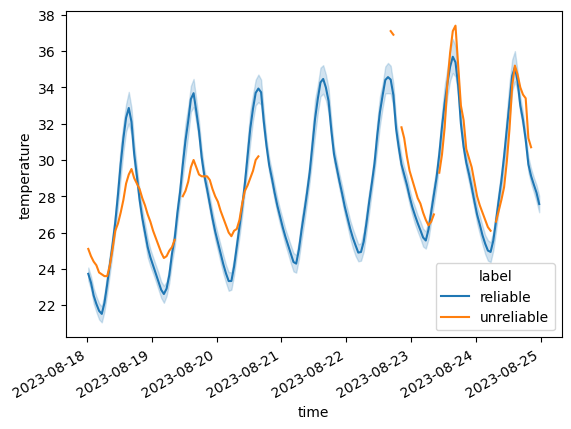

In [ ]:
qc.comparison_lineplot(
    ts_df,
    unreliable_stations,
    label_discarded="unreliable",
    label_kept="reliable",
    individual_discard_lines=True,
)

Filtering out unreliable stations should be the first step of the time series-based QC, since otherwise QC functions may return misleading results:

In [ ]:
reliable_ts_df = ts_df.drop(columns=unreliable_stations)

## Elevation adjustment (optional)

Due to the [atmospheric lapse rate](https://en.wikipedia.org/wiki/Lapse_rate), stations at lower elevations are usually expected to be consistently warmer than its counterparts at higher elevations (except under, e.g., the occurrence of [inversion](https://en.wikipedia.org/wiki/Inversion_(meteorology))). Therefore, it is possible to adjust for the elevation the time series data frame - otherwise we may find, e.g., that a given station is consistently warmer because of an incorrect set up when in reality the difference is due to the elevation. This can be done using the `meteora.qc.elevation_adjustment` function, which besides the (wide) time series data frame, accepts an optional `atmospheric_lapse_rate` keyword argument (otherwise the default set in `meteora.settings.ATMOSPHERIC_LAPSE_RATE` is used):

In [ ]:
atmospheric_lapse_rate = 0.0065  # in C / m
adj_ts_df = qc.elevation_adjustment(
    reliable_ts_df,
    client.stations_gdf["altitude"],
    atmospheric_lapse_rate=atmospheric_lapse_rate,
)

Let us now plot the difference between the average elevation-adjusted and unadjusted temperature at each station:

mean    504.745763
min     370.000000
max     764.000000
Name: altitude, dtype: float64

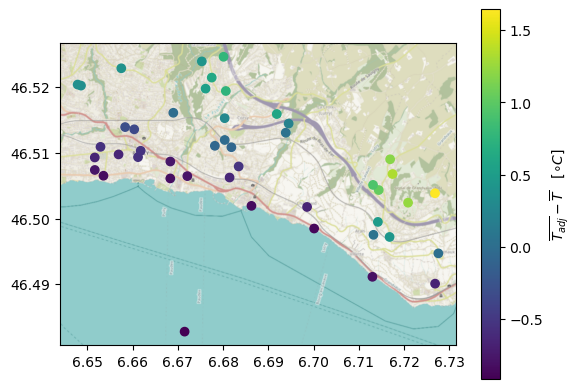

In [ ]:
ax = client.stations_gdf.assign(diff=adj_ts_df.mean() - reliable_ts_df.mean()).plot(
    "diff",
    legend=True,
    legend_kwds={"label": "$\overline{T_{adj}} - \overline{T} \quad [\circ C]$"},
)
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution="")
client.stations_gdf["altitude"].describe()[["mean", "min", "max"]]

Stations at higher elevations are added about 1.5 $^{\circ}$C whereas the ones at lower elevations are subtracted less than that (because of the smaller elevation difference between the mean and the minimum than between the maximum and the mean).

## Oulier stations

The `meteora.qc.get_outlier_stations` allows detecting when the measurements of a given station show suspicious deviations from a normal distribution. The function allow three optional keyword arguments, namely `low_alpha` and `high_alpha`, which are the respective values for the lower and upper tail that lead to a rejection of the null hypothesis (and that default to `meteora.settings.OUTLIER_LOW_ALPHA` and `meteora.settings.OUTLIER_LOW_ALPHA` respectively) as well as `station_outlier_threshold`, which is the maximum proportion of outlier measurements after which the respective station is flagged as faulty (defaults to `meteora.settings.station_outlier_threshold`).
As noted by Meier et al., (2017) [2], one of the main issues with Netatmo data are stations located in non-shaded areas, resulting in radiative errors, which is why the upper tail threshold is by default less permisive than its lower tail counterpart.

We can detect outlier stations separately for the initial data frame with (i) all (but mislocated) stations, (ii) reliable stations and (ii) reliable stations with elevation adjustment: 

In [ ]:
low_alpha = 0.01
high_alpha = 0.95
station_outlier_threshold = 0.2

for _ts_df, label in zip(
    [ts_df, reliable_ts_df, adj_ts_df], ["raw", "reliable", "elev. adjusted"]
):
    outlier_stations = qc.get_outlier_stations(
        _ts_df,
        low_alpha=low_alpha,
        high_alpha=high_alpha,
        station_outlier_threshold=station_outlier_threshold,
    )
    print(f"n. outlier stations from {label}: {len(outlier_stations)}")
outlier_stations = qc.get_outlier_stations(reliable_ts_df)

n. outlier stations from raw: 3
n. outlier stations from reliable: 1
n. outlier stations from elev. adjusted: 1


As we can see, initially 3 stations would be considered outliers, but after we exclude the unreliable stations, the number drops to 1 (with or without elevation adjustment). This highlights the importance of excluding unreliable stations first, otherwise we may wrongfully assume that the unreliable stations are systematically warmer or colder whereas in fact they likely do not have enough measurements to determine that.

For the reminder of the notebook, let us consider the outlier stations from the unadjusted reliable stations. We can again use the `comparison_lineplot` method:

<Axes: xlabel='time', ylabel='temperature'>

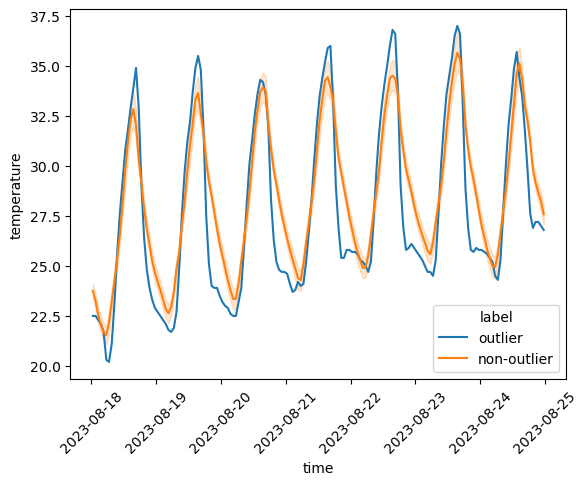

In [ ]:
qc.comparison_lineplot(
    reliable_ts_df,
    outlier_stations,
    label_discarded="outlier",
    label_kept="non-outlier",
)

Stations labeled as outliers clearly display an amplified temperature variation, especially for the maximum temperatures - in line with the radiative errors suggested by Meier et al. (2017) [2].

## Indoor stations

Netatmo stations may also be set indoors, in which case their diurnal cycles are assumed to be less correlated to the one from outdoor stations [3]. To that end, we can use the `meteora.qc.get_indoor_stations` function, which accepts an optional keyword argument `station_indoor_corr_threshold`, so that stations showing Pearson correlation (with the overall station median distribution) lower than the provided value are flagged as indoors (which defaults to `meteora.settings.STATION_INDOOR_CORR_THRESHOLD`):

In [ ]:
station_indoor_corr_threshold = 0.9

indoor_stations = qc.get_indoor_stations(
    reliable_ts_df, station_indoor_corr_threshold=station_indoor_corr_threshold
)
indoor_stations

['70:ee:50:00:71:0a',
 '70:ee:50:00:78:82',
 '70:ee:50:27:66:ba',
 '70:ee:50:28:89:d4',
 '70:ee:50:29:2c:ca',
 '70:ee:50:65:70:a2',
 '70:ee:50:9c:e8:d6']

In this example, 7 stations are considered to be indoors. We can check whether any indoor station is also considered an outlier:

In [ ]:
set(indoor_stations).intersection(set(outlier_stations))

set()

which is not the case. We can also plot the time series of temperature measurements for indoor and outdoor stations separately:

<Axes: xlabel='time', ylabel='temperature'>

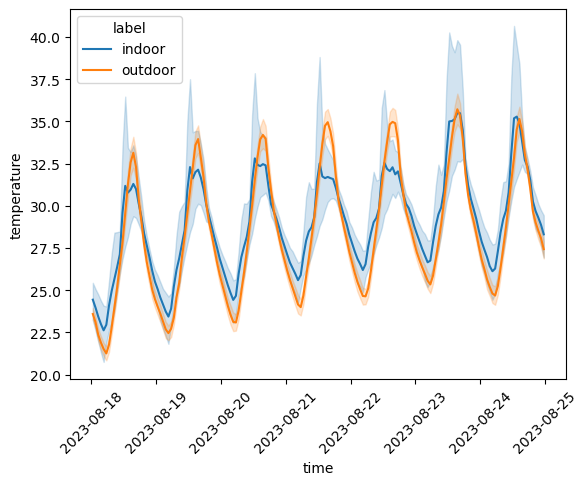

In [ ]:
qc.comparison_lineplot(
    reliable_ts_df,
    indoor_stations,
    label_discarded="indoor",
    label_kept="outdoor",
)

To conclude the QC, we can combine all the QC filters and plot the kept and discarded stations:

<Axes: xlabel='time', ylabel='temperature'>

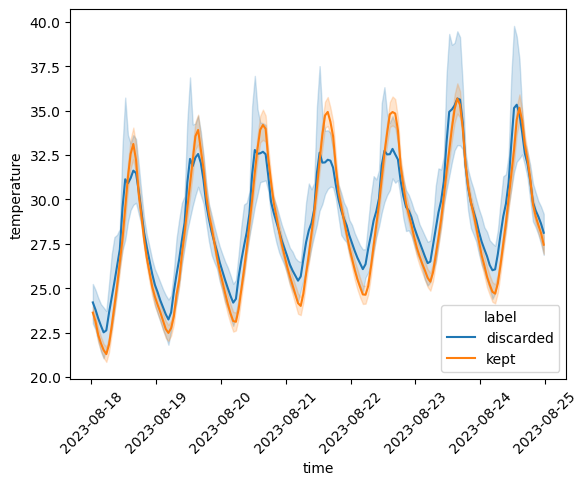

In [ ]:
discarded_stations = list(set(outlier_stations) | set(indoor_stations))
qc.comparison_lineplot(
    reliable_ts_df,
    list(set(outlier_stations) | set(indoor_stations)),
)

## Comparison with official data

Finally, we can compare the time series of temperature measurements of the CWS data (before and after QC) with its counterpart from official stations. To that end, we will get the data from [Agrometeo](https://www.agrometeo.ch) and the [Global Historical Climatology Network hourly (GHCNh)](https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly):

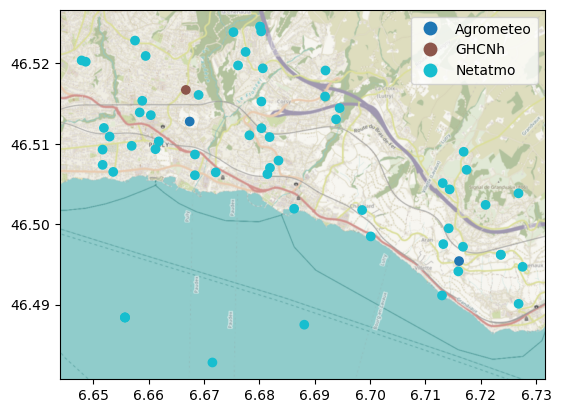

In [ ]:
# official
# need to specify the crs for agrometeo, otherwise it will be epsg:21781
agrometeo_client = AgrometeoClient(region, crs=crs)
ghcnh_client = GHCNHourlyClient(region)

client_dict = {
    "Netatmo": client,
    "Agrometeo": agrometeo_client,
    "GHCNh": ghcnh_client,
}
ax = pd.concat(
    [
        client_dict[client_label].stations_gdf.assign(source=client_label)
        for client_label in client_dict
    ]
).plot("source", legend=True)
cx.add_basemap(ax, crs=crs, attribution="")

There are two Agrometeo stations and one from GHCNh in the study area, which contrasts with the high spatial density of Netatmo CWS. Let us now get the time series of temperature data for the study period:

In [ ]:
# specify hourly `scale` for Agrometeo, otherwise is 10-minutes.
agrometeo_ts_df = agrometeo_client.get_ts_df(variables, start, end, scale="hour")
ghcnh_ts_df = ghcnh_client.get_ts_df(variables, start, end)

[########################################] | 100% Completed | 101.51 ms


We can now plot the time series separately. To have more flexibility, we will use the long-form data frames (note that we thus need to exlude the mislocated stations again, which were already excluded from the wide-form data frame but not from the long-form one):

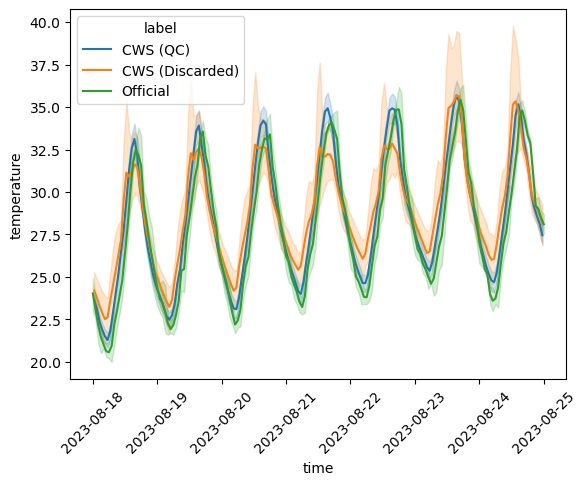

In [ ]:
all_discards = list(
    set(discarded_stations) | set(unreliable_stations) | set(mislocated_stations)
)
ax = sns.lineplot(
    pd.concat(
        [
            ts_df.assign(label=label)
            for ts_df, label in zip(
                [
                    long_ts_df.drop(all_discards, errors="ignore"),
                    long_ts_df.loc[discarded_stations],
                    pd.concat([agrometeo_ts_df, ghcnh_ts_df]),
                ],
                ["CWS (QC)", "CWS (Discarded)", "Official"],
            )
        ]
    )
    .droplevel("station_id")
    .reset_index(),
    x="time",
    y="temperature",
    hue="label",
)
ax.tick_params(axis="x", labelrotation=45)

We can observe how, unlike the discarded CWS, the CWS that pass QC have a very similar trend as the official stations. Although this is beyond the scope of this notebook, note that even after QC, CWS seem to be slightly warmer than the official stations, but this may be due to elevation differences as well as the urban heat island effect.

## References

1. Muller, C. L., Chapman, L., Johnston, S., Kidd, C., Illingworth, S., Foody, G., ... & Leigh, R. R. (2015). Crowdsourcing for climate and atmospheric sciences: current status and future potential. International Journal of Climatology, 35(11), 3185-3203.
2. Fred Meier, Daniel Fenner, Tom Grassmann, Marco Otto, and Dieter Scherer. Crowdsourcing air temperature from citizen weather stations for urban climate research. *Urban Climate*, 19:170–191, 2017.
3. Adrien Napoly, Tom Grassmann, Fred Meier, and Daniel Fenner. Development and application of a statistically-based quality control for crowdsourced air temperature data. *Frontiers in Earth Science*, pages 118, 2018.